In [1]:
import argparse
from pathlib import Path
from sklearn import metrics
import os
import pandas as pd
import mlflow

from mlflow.tracking import MlflowClient

In [2]:
def select_first_file(path):
    """Selects first file in folder, use under assumption there is only one file in folder
    Args:
        path (str): path to directory or file to choose
    Returns:
        str: full path of selected file
    """
    files = os.listdir(path)
    for file in files:
        if file.endswith('.csv'):
            return os.path.join(path, file)

In [3]:
def main(args):
    """Main function of the script."""

    # paths are mounted as folder, therefore, we are selecting the file from folder
    test_df = pd.read_csv(select_first_file(args.test_data))
    # Extracting the label column
    y_test = test_df.pop("is_bug_inc")
    # convert the dataframe values to array
    X_test = test_df

    # Load the model from input port
    model =  mlflow.sklearn.load_model(args.model_input) 

    # ---------------- Model Evaluation ---------------- #
    yhat_test, score = model_evaluation(X_test, y_test, model, args.evaluation_output)

    # ----------------- Model Promotion ---------------- #
    if args.runner == "CloudRunner":
        predictions, deploy_flag = model_promotion(args.model_name, args.evaluation_output, X_test, y_test, yhat_test, score)

def model_evaluation(X_test, y_test, model, evaluation_output):
    output_data = X_test.copy()

    # Get predictions to y_test (y_test)
    yhat_test = model.predict(X_test.values)

    # Save the output data with feature columns, predicted cost, and actual cost in csv file
    output_data["real_label"] = y_test
    output_data["predicted_label"] = yhat_test
    output_data.to_csv((Path(evaluation_output) / "predictions.csv"))

    # Evaluate Model performance with the test set
    fpr, tpr, thresholds = metrics.roc_curve(y_test, yhat_test)
    precision = metrics.precision_score(y_test, yhat_test)
    recall = metrics.recall_score(y_test, yhat_test)
    f1 = metrics.f1_score(y_test, yhat_test)
    auc = metrics.auc(fpr, tpr)

    # Print score report to a text file
    (Path(evaluation_output) / "score.txt").write_text(
        f"Scored with the following model:\n{format(model)}"
    )
    with open((Path(evaluation_output) / "score.txt"), "a") as outfile:
        outfile.write("Precision: {precision.2f} \n")
        outfile.write("Recall: {recall.2f} \n")
        outfile.write("F1: {f1.2f} \n")
        outfile.write("AUC: {auc.2f} \n")

    mlflow.log_metric("test precision", precision)
    mlflow.log_metric("test recall", recall)
    mlflow.log_metric("test f1", f1)
    mlflow.log_metric("test auc", auc)

    return yhat_test, f1

def model_promotion(model_name, evaluation_output, X_test, y_test, yhat_test, score):
    
    scores = {}
    predictions = {}

    client = MlflowClient()

    for model_run in client.search_model_versions(f"name='{model_name}'"):
        model_version = model_run.version
        mdl = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/{model_version}")
        predictions[f"{model_name}:{model_version}"] = mdl.predict(X_test)
        scores[f"{model_name}:{model_version}"] = metrics.f1_score(
            y_test, predictions[f"{model_name}:{model_version}"])

    if scores:
        if score > max(list(scores.values())):
            deploy_flag = 1
        else:
            deploy_flag = 0
    else:
        deploy_flag = 1
    print(f"Deploy flag: {deploy_flag}")

    with open((Path(evaluation_output) / "deploy_flag"), 'w') as outfile:
        outfile.write(f"{int(deploy_flag)}")

    # add current model score and predictions
    scores["current model"] = score
    predictions["currrent model"] = yhat_test

    perf_comparison_plot = pd.DataFrame(
        scores, index=["f1 score"]).plot(kind='bar', figsize=(15, 10))
    perf_comparison_plot.figure.savefig("perf_comparison.png")
    perf_comparison_plot.figure.savefig(Path(evaluation_output) / "perf_comparison.png")

    mlflow.log_metric("deploy flag", bool(deploy_flag))
    mlflow.log_artifact("perf_comparison.png")

    return predictions, deploy_flag

In [6]:
# Define Arguments for this step

class MyArgs:
    def __init__(self, /, **kwargs):
        self.__dict__.update(kwargs)

args = MyArgs(
                model_name = "crrisk-model-pipeline-4steps",
                model_input = "local_run/train/train_exp3",
                test_data = "local_run/prep_outputs/test",
                evaluation_output = "local_run/evaluate/evaluate_3",
                runner = "CloudRunner"
                )

os.makedirs(args.evaluation_output, exist_ok = True)

Model name: crrisk-model-pipeline-4steps
Model path: local_run/train/train_exp3
Test data path: local_run/prep_outputs/test
Evaluation output path: local_run/evaluate/evaluate_3
Deploy flag: 1


/anaconda/envs/crrisk/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


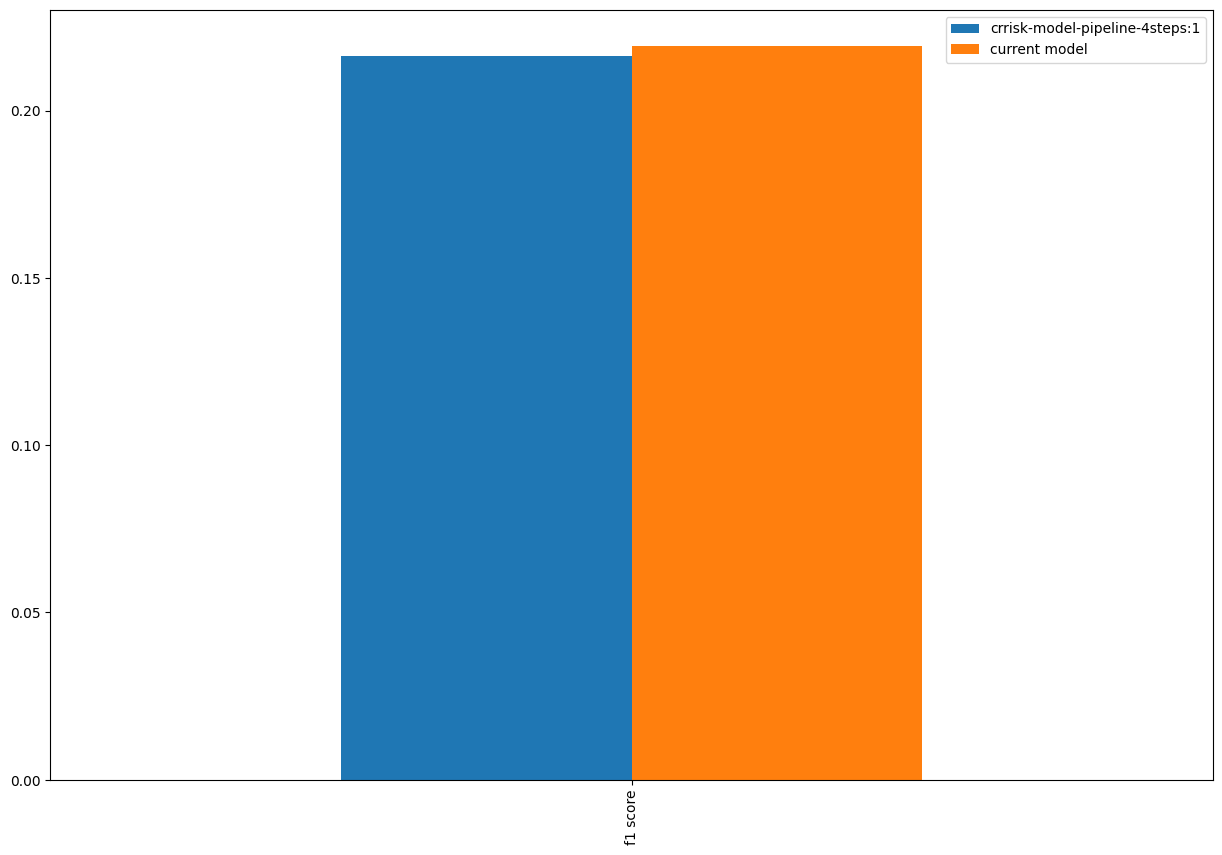

In [7]:
mlflow.start_run(run_name='evaluate_3')

lines = [
    f"Model name: {args.model_name}",
    f"Model path: {args.model_input}",
    f"Test data path: {args.test_data}",
    f"Evaluation output path: {args.evaluation_output}",
]

for line in lines:
    print(line)

main(args)

mlflow.end_run()